<a href="https://colab.research.google.com/github/MohebZandi/Comupter_Vision/blob/main/Transfer_Learning_1400_12_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning --- MNIST->FMNIST
## SECTION: Transfer learning
### LECTURE: Transfer learning: MNIST->FMNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202108

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torchvision
import torchvision.transforms as T

from sklearn.model_selection import train_test_split

import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

## Import and process the data

In [ ]:
### MNIST data

# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels, normalize, reshape
labelsT   = torch.tensor( data[:,0] ).long()
data      = data[:,1:]
dataNorm  = data / np.max(data)
dataNormT = torch.tensor( dataNorm.reshape(dataNorm.shape[0],1,28,28) ).float()

# split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataNormT, labelsT, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 32
numbers_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
numbers_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
### FMNIST data

# transformations
transform = T.Compose([ T.ToTensor(), T.Normalize(.5,.5) ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize    = 32
fashion_train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
fashion_test_loader  = DataLoader(testset, batch_size=len(testset))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Create the DL model

In [ ]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 20*int(expectSize**2)
      
      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,50)

      ### output layer
      self.out = nn.Linear(50,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):
      
      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')
      
      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x
  
  # create the model instance
  net = mnistNet(printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (NOTE: Using SGD here to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.005)

  return net,lossfun,optimizer

## Create a function that trains the model

In [ ]:
# a function that trains the model

# input the network and the number of epochs to train
def function2trainTheModel(net,train_loader,test_loader,numepochs=10):

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compute test accuracy
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


## Train the source model on numbers and show the results

In [ ]:
# create a new model
numberNet,lossfun,optimizer = createTheMNISTNet()

# train it on numbers data
trainAcc,testAcc,losses,numberNet = function2trainTheModel(numberNet,numbers_train_loader,numbers_test_loader,5)

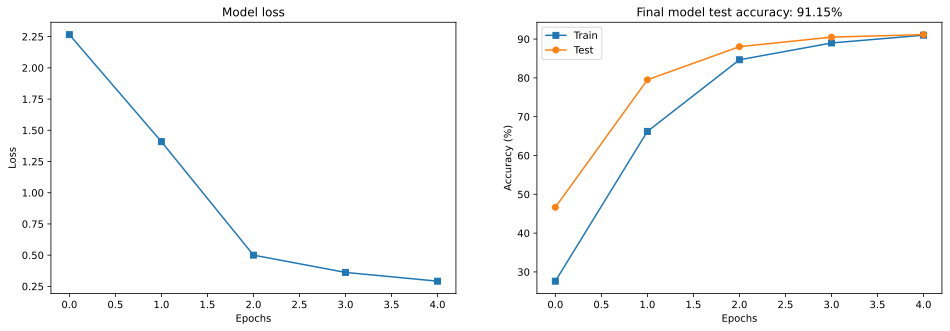

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Test the model on the fashion data

In [ ]:
# test the model with fashion data

# extract X,y from FASHION test dataloader
X,y = next(iter(fashion_test_loader))
yHat = numberNet(X)

# the test
fashionAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

print(f'NUMBERNET performance on FASHION data: {fashionAcc:.2f}%')

NUMBERNET performance on FASHION data: 5.29%


## Fine-tune the model using one batch

In [ ]:
# create the target model
fashionNet,lossfun,optimizer = createTheMNISTNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(fashionNet.named_parameters(),numberNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

In [ ]:
# Note: you'd think that the following should work, but deepcopy() doesn't copy many features of classes.
# Try it and see what happens!
#DUDL_transfer_MNISTtoFMNIST = copy.deepcopy( numberNet )

In [ ]:
%%time
# now re-train the network on the numbers data

trainAcc,testAcc,losses,fashionNet = function2trainTheModel(
                                         fashionNet,fashion_train_loader,fashion_test_loader,5)

CPU times: user 3min 10s, sys: 2.94 s, total: 3min 13s
Wall time: 3min 13s


In [ ]:
print(f'numberNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'numberNet TEST accuracy: {testAcc[-1]:.2f}%')

numberNet TRAIN accuracy: 86.35%
numberNet TEST accuracy: 86.29%


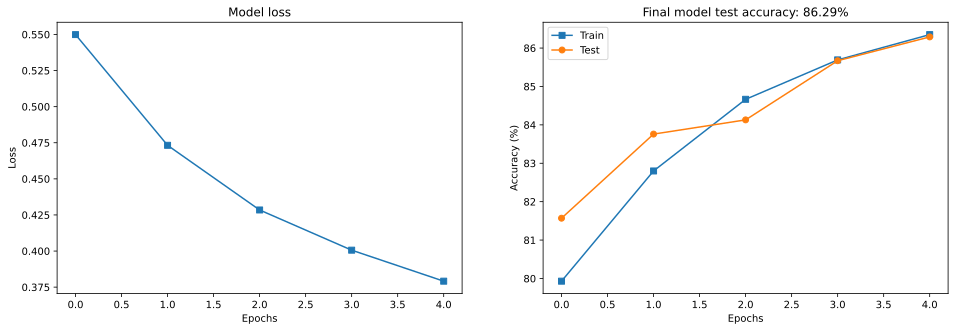

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# COURSE: A deep understanding of deep learning   ---- letters -> numbers
## SECTION: Transfer learning
### LECTURE: CodeChallenge: letters to numbers
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202108

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy
from sklearn.model_selection import train_test_split


# NEW! for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Import the data

In [ ]:
# download the datasets
letterdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)
numberdata = torchvision.datasets.EMNIST(root='emnist',split='digits',download=True)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [ ]:
# transformations on the letter data

# remove N/A class
letterCategories = letterdata.classes[1:]
print(letterCategories)
labels = copy.deepcopy(letterdata.targets)-1
print(labels.unique())

# transform to 4D tensor for conv layers (and transform from int8 to float)
letterImages = letterdata.data.view([letterdata.data.shape[0],1,28,28]).float()
letterImages /= torch.max(letterImages)


# split the images and convert to dataloaders
train_data,test_data, train_labels,test_labels = train_test_split(letterImages, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize = 32
letter_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
letter_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])


In [ ]:
### transformations on numbers data

# transform to 4D tensor for conv layers (and transform from int8 to float)
numberImages = numberdata.data.view([numberdata.data.shape[0],1,28,28]).float()
numberImages /= torch.max(numberImages)


# split the images and convert to dataloaders
train_data,test_data, train_labels,test_labels = train_test_split(numberImages, numberdata.targets, test_size=.1)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize = 32
number_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
number_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

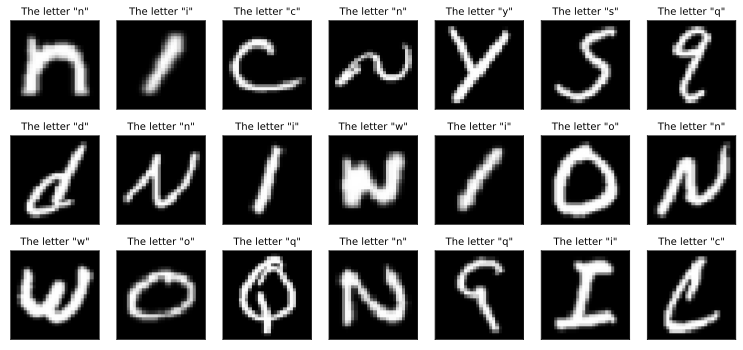

In [ ]:
# visualize some letters
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of letter data
X,y = next(iter(letter_train_loader))

for i,ax in enumerate(axs.flatten()):
  
  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  letter = letterCategories[y[i]]
  
  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The letter "%s"'%letter,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

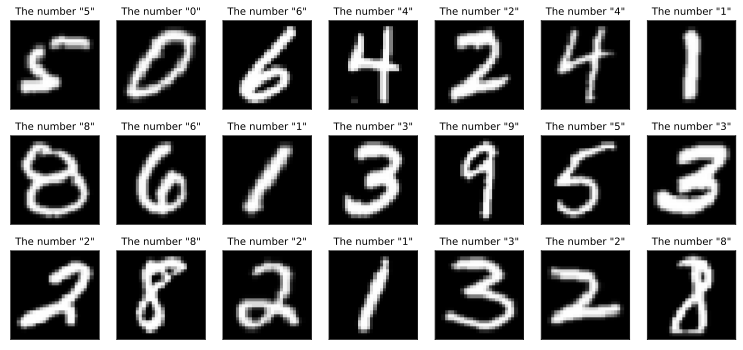

In [ ]:
# visualize some numbers
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of number data
X,y = next(iter(number_train_loader))

for i,ax in enumerate(axs.flatten()):
  
  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  number = y[i].item()
  
  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The number "%s"'%number,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

## Create the DL model

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      
      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,26)

    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')
      
      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

## Create a function that trains the model

In [ ]:
# a function that trains the model

def function2trainTheModel(net,optimizer,train_loader,test_loader,numepochs=10):

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):
    print('Epoch Number starts: ', epochi + 1)

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()
    
    print('Epoch Number finished: ', epochi + 1)

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

## Train the model on the letters

In [ ]:
%%time
# create a new model
letterNet,lossfun,optimizer = makeTheNet()

trainLoss,testLoss,trainErr,testErr,letterNet = function2trainTheModel(
                                                letterNet,optimizer,letter_train_loader,letter_test_loader,5)

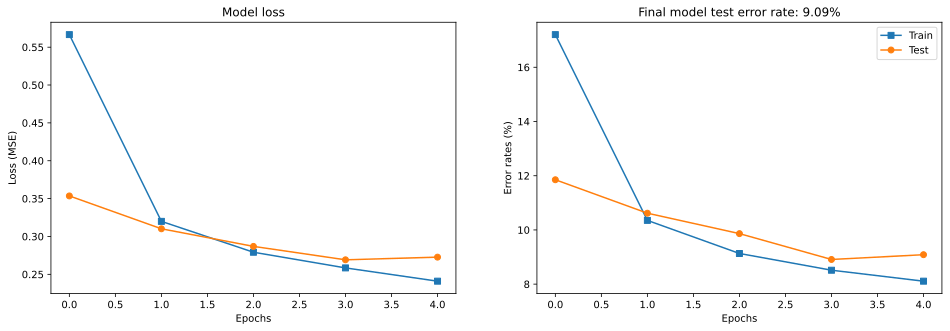

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

## Test the model on the number data

In [ ]:
# extract X,y from NUMBER test dataloader
X,y = next(iter(number_test_loader))
X = X.to(device)
y = y.to(device)

letterNet.eval()
yHat = letterNet(X)

# the test
numberAcc = 100*torch.mean((torch.argmax(yHat,axis=1)!=y).float())

print(f'numberNet error rate on NUMBER data: {numberAcc:.2f}%')

numberNet error rate on NUMBER data: 95.84%


## Fine-tune the model with one training batch

In [ ]:
# create the target model
numberNet,lossfun,optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(numberNet.named_parameters(),letterNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

## Important Part ----------> Tuning of Number of Nodes in FFN Layer

In [ ]:
# check out the network
print(numberNet)
print(' ')

# and the final layer
print(numberNet.fc2)

# replace the final layer to have 10 outputs instead of 26
numberNet.fc2 = nn.Linear(50,10)

# and check it again
print(' ')
print(numberNet)

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)
 
Linear(in_features=50, out_features=26, bias=True)
 
emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
%%time
# now re-train the network on the numbers data

trainLoss,testLoss,trainErr,testErr,numberNet = function2trainTheModel(
                                                   numberNet,optimizer,number_train_loader,number_test_loader,1)

CPU times: user 32.6 s, sys: 722 ms, total: 33.4 s
Wall time: 33.7 s


In [ ]:
print(f'numberNet TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr[-1]:.2f}%')

numberNet TRAIN error rate: 2.58%
numberNet TEST error rate: 1.37%


## Try again, only train output layer

In [ ]:
# create the target model
numberNet2,lossfun,optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(numberNet2.named_parameters(),letterNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

print(numberNet2)
# adjust number of output units
numberNet.fc2 = nn.Linear(50,10)

print(' ')
print(numberNet2)


# freeze all layers except output
for p in numberNet2.named_parameters():
  if not 'fc2' in p[0]:
    p[1].requires_grad = False

# print(' ')
for p in numberNet2.named_parameters():
    print(p[0])
    


emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)
 
emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)
conv1.weight
conv1.bias
bnorm1.weight
bnorm1.bias
conv2.weight
con

In [ ]:
%%time
# now re-train the network on the numbers data

trainLoss, testLoss, trainErr, testErr, numberNet2 = function2trainTheModel(
                                                   numberNet2,optimizer,number_train_loader,number_test_loader,5)

Epoch Number starts:  1
Epoch Number finished:  1
Epoch Number starts:  2
Epoch Number finished:  2
Epoch Number starts:  3
Epoch Number finished:  3
Epoch Number starts:  4
Epoch Number finished:  4
Epoch Number starts:  5
Epoch Number finished:  5
CPU times: user 1min 25s, sys: 2.92 s, total: 1min 28s
Wall time: 1min 27s


In [ ]:
print(f'numberNet TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr[-1]:.2f}%')

numberNet TRAIN error rate: 2.02%
numberNet TEST error rate: 2.23%


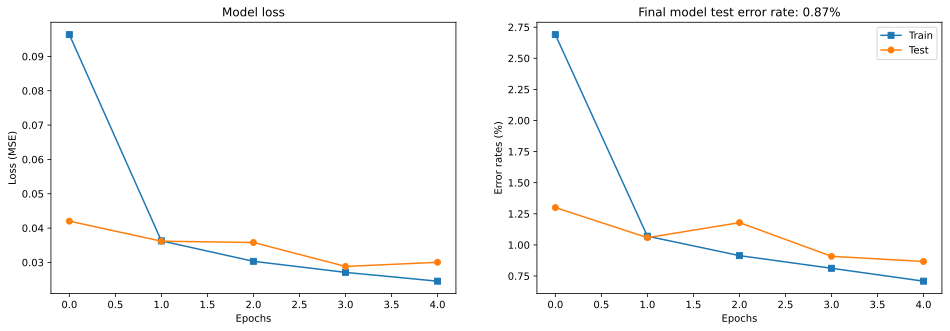

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

# COURSE: A deep understanding of deep learning --- Transfer learning with ResNet18
## SECTION: Transfer learning
### LECTURE: Transfer learning with ResNet18
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202108

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Import a dataset

In [3]:
### Note: resnet is trained for images in a specific range (NOT [-1,1]).
#         That changes the mean/std normalization values in the transform.

# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# test_loader  = DataLoader(testset, batch_size=256,shuffle=True)

In [5]:
# check out the shape of the datasets
print('Data shapes (train/test):')
print( trainset.data.shape )
print( testset.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [6]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 3x96x96
# And they are not normalized!

# but...
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400))


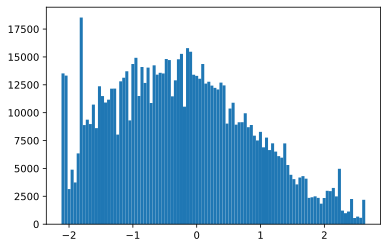

In [7]:
# histogram of the data
plt.hist(X.data.numpy().flatten(),100);

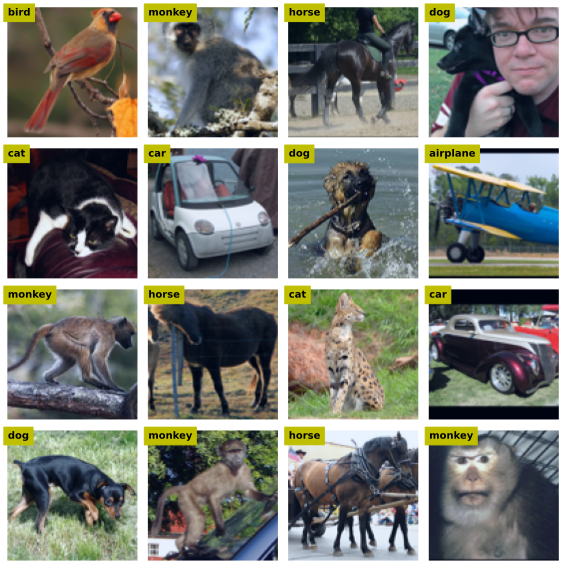

In [8]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(8,8))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  
  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

## Import and inspect the resnet model

In [12]:
resnet = torchvision.models.resnet18(pretrained=True)

In [13]:
# let's inspect this network
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
from torchsummary import summary
summary(resnet.to(device),(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [12]:
# Freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad = False

    # python note: the above operation can be implemented in-line:
    #p.requires_grad_(False)

In [13]:
# change the final layer
resnet.fc = nn.Linear(512,10)

In [ ]:
summary(resnet.to(device),(3,96,96))

In [ ]:
# push the model to the GPU (if using)
resnet.to(device)

## Train the model

In [16]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(),lr=0.001,momentum=.9)

In [17]:
%%time
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  resnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = resnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  resnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = resnet(X)
      loss = lossfun(yHat,y)
    
    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')


Finished epoch 1/10. Test accuracy = 73.89%
Finished epoch 2/10. Test accuracy = 76.42%
Finished epoch 3/10. Test accuracy = 76.45%
Finished epoch 4/10. Test accuracy = 77.56%
Finished epoch 5/10. Test accuracy = 77.84%
Finished epoch 6/10. Test accuracy = 78.39%
Finished epoch 7/10. Test accuracy = 78.43%
Finished epoch 8/10. Test accuracy = 78.92%
Finished epoch 9/10. Test accuracy = 78.88%
Finished epoch 10/10. Test accuracy = 78.97%
CPU times: user 2min 52s, sys: 1.03 s, total: 2min 53s
Wall time: 2min 53s


## Visualize the performance

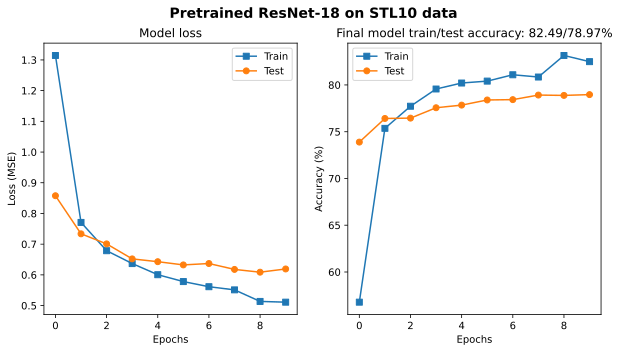

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

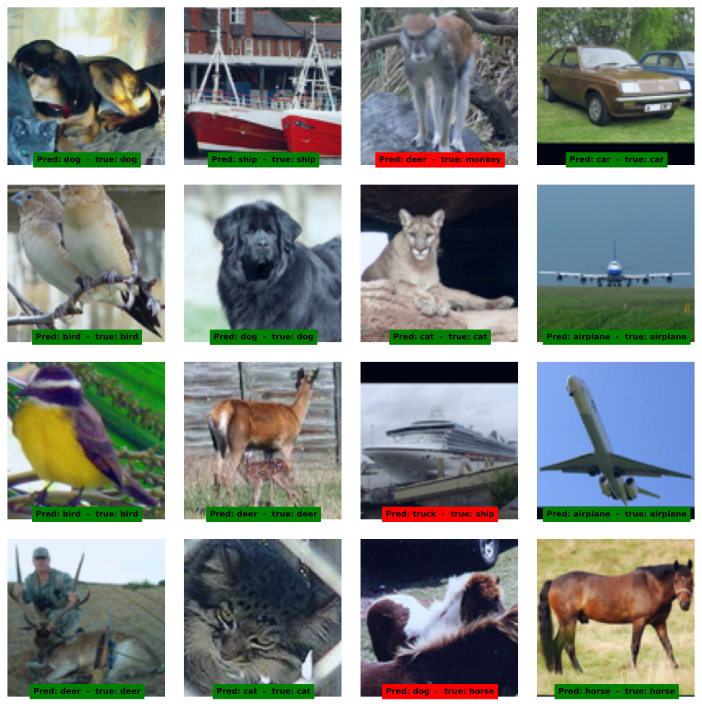

In [26]:
# inspect a few random images

test_loader  = DataLoader(testset, batch_size=256, shuffle=True)

X,y = iter(test_loader).next()
X = X.to(device)
y = y.to(device)
resnet.to(device)
resnet.eval()
predictions = torch.argmax( resnet(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  
  # show the image
  ax.imshow(pic)
  
  
  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

# COURSE: A deep understanding of deep learning --- Transfer learning with VGG16
## SECTION: Transfer learning
### LECTURE: Transfer learning with VGG16
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202108

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Import a dataset

In [3]:
### Note: resnet is trained for images in a specific range (NOT [-1,1]).
#         That changes the mean/std normalization values in the transform.

# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# check out the shape of the datasets
print('Data shapes (train/test):')
print( trainset.data.shape )
print( testset.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [5]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 3x96x96
# And they are not normalized!

# but...
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400))


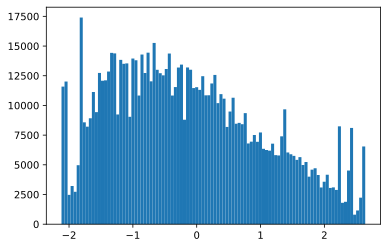

In [6]:
# histogram of the data
plt.hist(X.data.numpy().flatten(),100);

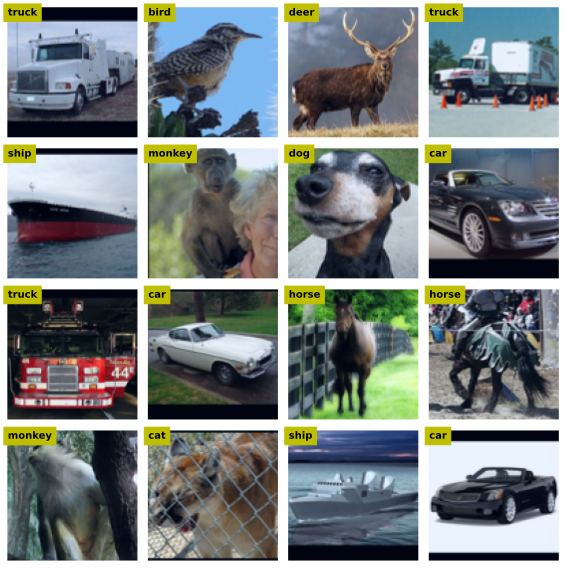

In [7]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(8,8))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  
  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

## Import and inspect the VGG model

In [8]:
vggnet = torchvision.models.vgg16(pretrained=True)

In [9]:
# let's inspect this network
vggnet

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
from torchsummary import summary
summary(vggnet.to(device),(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [11]:
# Freeze all layers (final layer changed later)
for p in vggnet.parameters():
    p.requires_grad = False

    # python note: the above operation can be implemented in-line:
    #p.requires_grad_(False)

In [12]:
# change the final layer
vggnet.classifier[6] = nn.Linear(4096, 10)

# OR

# vggnet.classifier[6] = nn.Linear(vggnet.classifier[6].in_features, 10)

In [13]:
summary(vggnet.to(device),(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [14]:
# push the model to the GPU (if using)
vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Train the model

In [15]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vggnet.parameters(),lr=0.001,momentum=.9)

In [17]:
%%time
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  vggnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = vggnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  vggnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = vggnet(X)
      loss = lossfun(yHat,y)
    
    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')


Finished epoch 1/10. Test accuracy = 90.55%
Finished epoch 2/10. Test accuracy = 91.60%
Finished epoch 3/10. Test accuracy = 91.38%
Finished epoch 4/10. Test accuracy = 91.32%
Finished epoch 5/10. Test accuracy = 91.58%
Finished epoch 6/10. Test accuracy = 91.52%
Finished epoch 7/10. Test accuracy = 91.59%
Finished epoch 8/10. Test accuracy = 91.32%
Finished epoch 9/10. Test accuracy = 91.36%
Finished epoch 10/10. Test accuracy = 91.35%
CPU times: user 6min 45s, sys: 11 s, total: 6min 56s
Wall time: 6min 58s


## Visualize the performance

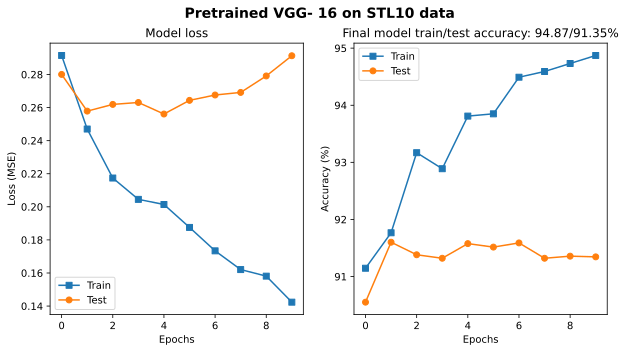

In [18]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained VGG- 16 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

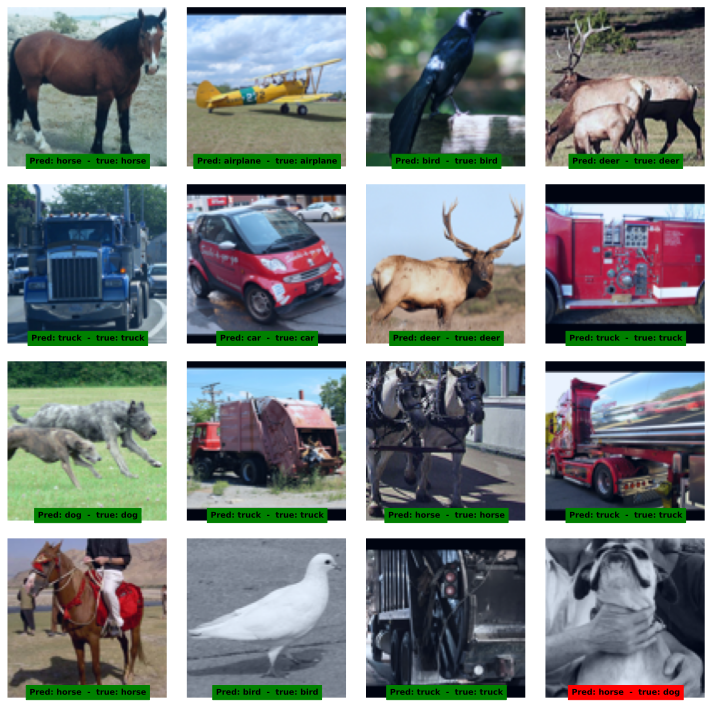

In [19]:
# inspect a few random images

test_loader  = DataLoader(testset, batch_size=256, shuffle=True)

X,y = iter(test_loader).next()
X = X.to(device)
y = y.to(device)
vggnet.to(device)
vggnet.eval()
predictions = torch.argmax( vggnet(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  
  # show the image
  ax.imshow(pic)
  
  
  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()